In [10]:
def from_therion_sql_enhanced(  inputfile, 
                                cavename=None, 
                                crs=None, 
                                rights=None,
                                citation=None ):
    """ This function 
    1. loads all the data from Therion sql, 
    2. add flags on shots and stations,
    3. regroupe nodes with same exact geographic coordinates,
    4. rename nodes,

    5. optionnaly remove nodes with srf, dpl, rmv, art, or spl flags 
    6. optionnaly return a networkx graph or karstnet Kgraph

    #potential Therion node flags 
    # 'ent' = entrance, 'con' = continuation, 'fix' = fixed, 
    # 'spr' = spring, 'sin' = sink, 'dol' = doline, 'dig' = dig, 
    # 'air' =air-draught, 'ove' = overhang, 'arc' = arch attributes  
    #potential Therion shot flags:
    # 'dpl' = duplicate, 'srf' = surface shots 

    Parameters
    ----------
    inputfile : string
        path to the SQL file exported with Therion

    cavename : string, optional
        Name of the cave. Will be attached to the graph as metadata. By default None

    crs : string, optional
        Coordinate reference. Will be attached to the graph as metadata. By default None

    rights : string, optional
        Information about the rights related to the dataset. Example: CC-BY-NC-SA, ... . Will be attached to the graph as metadata. By default None

    citation : string, optional
        Description on how to cite the dataset. Will be attached to the graph as metadata. By default None

    Returns
    -------
    G : networkx graph 
        with optional properties on nodes and edges:
        Dictionnaries always present on node: 'fulladdress', 'idsql'
        Optional dictionnaries on node: 'flags', 'pos', 'splays'
        Optional dictionnaries on edge: 'flags'

    Example:
    --------

    >>> from_therion_sql_enhanced('inputfilepath.sql')

    Metadata can be accessed with:
    >>> G.graph #not to confuse with the Kg.graph from Karstnet
    List of attribute names attached to the nodes:
    >>> set([k for n in G.nodes for k in G.nodes[n].keys()])
    List of attribute names attached to the nodes:
    >>> set([k for n in G.edges for k in G.edges[n].keys()])
    Dictionnaries can be accessed with:
    >>> nx.get_node_attribute(G,'attribute_name')


    """   

    import time 
    import networkx as nx
    import sqlite3
    from sqlite3 import OperationalError
    import sys

    def list2dict(key_list, value_list):
        """Transform list to dictionnary by regouping values in list for identical keys. 
        Using dictionnary comprehension.

        Parameters
        ----------
        key_list : list
            Dictionnary keys. Usually a list of int
        value_list : list
            Dictionnary values. Can be a list of int, flot, array, or list.

        Returns
        -------
        dictionnary

        """
        
        return {key : [value_list[idx] 
                for idx in range(len(value_list)) if key_list[idx]== key]
                for key in set(key_list)}

    def read_sql_file(basename):
        """
        Parameters
        ----------
        basename : str
            name of the sql database. without the extension.

        Returns
        -------
        c : TYPE
            DESCRIPTION.
        """
        # sql_name = basename #+ '.sql'

        try:
            conn = sqlite3.connect(':memory:')
            conn.executescript(open(basename,  encoding='utf-8-sig').read())
        #    	conn.executescript(open('../data/g_huttes.sql').read())
        except OSError:
            print("IMPORT ERROR: Could not import {}".format(basename))
        #    return

        # Read the SQL file
        c = conn.cursor()
        return c
    
    def extract_flags(c,type, return_type='dictionnary'):
        """  Extract flags attached to the stations or the shots to the form of a dictionnary.
        Shot Flags currently present in Therion:
        'dpl' = duplicate, 'srf' = surface shots

        Parameters
        ----------
        c : sqlite3.Cursor
            SQL database request cursor. this is the output of the function read_sql_file(basename).
        type : string
            To select wether its a shot flag or a station flag

        Returns
        -------
        dict
            Dictionnary with flags as keys, and each key containing a list of id or list of tuples.
        """ 

        flag_list=[]

        if type == 'shot':
            #extract shot flags with from-to info
            try:
                c.execute('select SHOT_FLAG.FLAG, SHOT.FROM_ID, SHOT.TO_ID from SHOT, SHOT_FLAG  \
                                            where SHOT.ID = SHOT_FLAG.SHOT_ID')
            except OperationalError:
                print(f'Cannot find sql. Verify that .sql exists or that the path is correct ')

            keys = []
            values = []
            id_from = []
            id_to = []
            for s in c.fetchall():
                #create list of tuple from all the links (from to)
                keys.append((s[1],s[2]))
                id_from.append(s[1])
                id_to.append(s[2])
                #create list with all the flags as value
                values.append(s[0])
            
            if return_type == 'lists':
                return id_from,id_to,values

            if return_type == 'dictionnary':
                return list2dict(keys, values) #dict(zip(keys, values))

        elif type == 'station':
            try:
                c.execute('select STATION_ID, FLAG from STATION_FLAG')
            except OperationalError:
                print(f'Cannot find sql. Verify that .sql exists or that the path is correct ')
            keys = []
            values = []
            for s in c.fetchall():
                #create list of station id
                keys.append(s[0])
                #create list with all the flags as value
                values.append(s[1])

            if return_type == 'lists':
                return keys,values

            if return_type == 'dictionnary':
                return list2dict(keys, values) #dict(zip(keys, values))


    #########################################
    ########################################


    #to check running time
    start_time = time.time()

    #read the sql database
    c = read_sql_file(inputfile)
    
    # import all LINKS 
    ###############
    print(f'Therion Import -- Importing all links (including splays) -- {(time.time() - start_time)}s')
    try:
        c.execute('select FROM_ID, TO_ID from SHOT')
    except OperationalError as e:
        print(f'1. Cannot find sql here: {inputfile}\n verify that .sql exists or that the path is correct ')
        raise e
        
    links_all = []
    for l in c.fetchall():
        links_all.append(l)
   
    
    # import NODES
    ###############################################################
    #import all nodes
    #prevents extraction of anonymous survey point symbol (- or .)  
    print(f'Therion Import -- Importing all nodes data (including splays) -- {(time.time() - start_time)}s')

    try:   
        c.execute('select st.ID, st.NAME, st.SURVEY_ID, FULL_NAME, X, Y, Z from STATION st \
                left join SURVEY su on st.SURVEY_ID = su.ID') 
    except OperationalError:
        print(f'2. Cannot find sql here: {inputfile}\n verify that .sql exists or that the path is correct ')
    
                           
    nodes_coord = [] # this is all the coordinates, including the splays
    nodes_id = [] # this all the ids, including the splays. (rename??)
    nodes_tree_structure = []
    for s in c.fetchall():
        #extract x,y,z nodes coordinates. this is all the coordinates, including splays
        nodes_coord.append([s[4], s[5], s[6]])
        #extract unique node id from Therion. this all the ids, including splays
        nodes_id.append(s[0])
        #extract full stree structure from Therion. this is all the tree-structure, including the splays
        if s[3]=='':
            nodes_tree_structure.append(f'{s[1]}')
        else:
            address = '.'.join(s[3].split('.')[::-1])            
            nodes_tree_structure.append(f'{address}.{s[1]}')
        # nodes_tree_structure.append('%s@%s'%(s[1],s[3]))
    #create dictionnary of the nodes coordinates
    coord = dict(zip(nodes_id,nodes_coord))
    #save tree structure in the form of two list, to prevent data loss when combining nodes
    #only take the stations
    list_tree_oldi = []
    list_tree_values = []
    for i, tree in enumerate(nodes_tree_structure):
        if tree.startswith(('.','-'))==False:#tree[0].isdigit():  
            list_tree_values.append(nodes_tree_structure[i])
            list_tree_oldi.append(nodes_id[i])
        #if tree.startwith(-) or tree.startwith(.):


    
    #create graph with all the links
    #################################
    print(f'Therion Import -- Create initial graph with all the data points (including splays) -- {(time.time() - start_time)}s')
    G = nx.Graph(cavename=cavename, crs=crs, original_data_rights=rights, citation=citation)
    G.add_edges_from(links_all)
    # if the nodes attributes are the same for two combined nodes, it seems that it does not affect the combining
    nx.set_node_attributes(G, coord, 'pos')
    # nx.set_node_attributes(G, tree_structure, 'tree_structure')

    
    # Import splay leg 
    ###################################
    ##################################################################
    #remove nodes that are anonymous survey point symbol (- or .)
    
    splay_id = []  #this is the sql id of the splay itself
    splay_coord = []
    try:
        c.execute('select st.ID, st.NAME, X, Y, Z from STATION st \
                where st.NAME in (".","-") or st.NAME like "%splay%"' )
    except OperationalError:
        print(f'3. Cannot find sql here: {inputfile}\n verify that .sql exists or that the path is correct ')
    
    for s in c.fetchall():
        #extract x,y,z nodes coordinates
        splay_coord.append([s[2], s[3], s[4]])
        #extract unique node id from Therion
        splay_id.append(s[0])

    #!!! remove splays from the nodes. they will be imported later
    if splay_id:
        G.remove_nodes_from(splay_id)
    else: 
        print('no splays legs to remove')
      
    # Import splay leg shot info on nodes in the form of a list of coordinates of the end of the shot. 
    #create dictionnary of the nodes coordinates for each splays. 
    #the dictionnary key corresponds to the id for each splay in the sql database
    coord = dict(zip(splay_id,splay_coord))

    #import links only for the nodes we exported
    string_id = ",".join(map(str,splay_id))
    try:
        c.execute('select FROM_ID, TO_ID from SHOT \
                where TO_ID in (%s)' % (string_id))
    except OperationalError:
        print(f'4. Cannot find sql here: {inputfile}\n verify that .sql exists or that the path is correct ')
    links = []
    for l in c.fetchall():
        links.append([l[0], l[1]])

    #replace splay node id with the station id to which the splay is shot from
    #for example, if 2,3,4 are splay id, and attached to station 1, then all the id will be 1
    #splays_dict = defaultdict(list)
    #make two lists of splays 1. station of departure, 2. coordinates for arrival
    #(make a drawing to explain this)
    list_splays_oldi=[]
    list_splays_pos=[]
    for link in links:   
        if link:
            list_splays_oldi.append(link[0])
            list_splays_pos.append(coord[link[1]])
            #splays_dict[link[0]].extend([coord[link[1]]]) 
    
    #nx.set_node_attributes(G, splays_dict, 'splays')   
    
   
    #COMBINE IDENTIDAL STATIONS
    #Rename nodes and get ride of duplicate nodes with identical position
    ##############################################################################
    ##############################################################################
    # this rename nodes with identical position with the same id, 
    # which automatically regroup the nodes with identical name into one.
     
    #pos2d = {key: value[0:2] for key, value in nx.get_node_attributes(G,'coord').items()}
    # plt.figure()
    # nx.draw(G,pos=pos2d)
    
    #find nodes with duplicate positions:
    #create a list of lists of index where the coordinates are the same
    print(f'Therion Import -- Combine Stations with identical x,y,z -- {(time.time() - start_time)}s')
    unique_pos = [list(x) for x in set(tuple(x) for x in list(nx.get_node_attributes(G,'pos').values()))]
    # print(len(unique_pos))
    duplicates = []
    for i,position in enumerate(unique_pos):
        if i%1000 == 0:
            print(f'{i}/{len(unique_pos)} unique positions')
        #this could be sped up by inversing the dictionnary key and values??
        duplicates.append([key for key,coord in G.nodes('pos') if coord==position])
        #duplicates_fulladdress.append([])


        
    #rename nodes 
    ########################################################################
    #duplicate nodes are renamed with the same name
    #create new ids dictionnary to replace the initial indexes  
    #create new ids with repeating values for idential node position 
    #################################################################
    newis = []  
    print(f'Therion Import -- Rename nodes -- {(time.time() - start_time)}s') 
    # print(f'len(duplicates) = {len(duplicates)}')
    for i, index in enumerate(range(len(duplicates))):
        if i%1000 == 0:
            print(f'{i}/{len(duplicates)} nodes to rename')
        newis = newis + [index]*len(duplicates[i])
        
    #flatten the list of list of old ids
    #####################################
    print(f'Therion Import -- concatenate old ic in a dictionnary -- {(time.time() - start_time)}s')
    concat_oldi = [j for i in duplicates for j in i]   
    #the dictionnary has to be in the form of dict keys are the old keys, and the value is the new key
    index_dict = dict(zip(concat_oldi, newis ))
    # index_fulladdress = dict(zip(concat_fulladdress,newis))

    # #extract full tree info
    # #########################
    # concat_fulladdress = []
    # for index in concat_oldi:
    #     concat_fulladdress.append(G.nodes('tree_structure')[index])
    
    print(f'Therion Import -- Relabel nodes -- {(time.time() - start_time)}s')
    #rename nodes (nodes with same geographic posiion will be "merged" under the same name)
    G = nx.relabel_nodes(G,index_dict)
    #drop edges that link the node to themselves. happen because of the combining the nodes.
    print(f'Therion Import -- remove self links -- {(time.time() - start_time)}s') 
    G.remove_edges_from(list(nx.selfloop_edges(G)))


    #Add attributes to the graph with the new ids,
    ################################################################
    print(f'Therion Import --add dictionnaries to graph -- {(time.time() - start_time)}s')  
    #combines the information for nodes that are regrouped
    #this steps has to be mande after the nodes have been regrouped, otherwise, 
    #the networkx function just gets rid of attribute values is they exist in two or more combined nodes

    #SPLAYS
    #######
    print(f'Therion Import -- add splays -- {(time.time() - start_time)}s') 
    list_splays_newi = [index_dict.get(item, item)  for item in list_splays_oldi]
    dict_splays = list2dict(list_splays_newi, list_splays_pos)
    nx.set_node_attributes(G, dict_splays, 'splays') 

    #TREE
    #####
    print(f'Therion Import -- add fulladdress -- {(time.time() - start_time)}s')
    list_tree_newi = [index_dict.get(item, item)  for item in list_tree_oldi]
    dict_tree = list2dict(list_tree_newi, list_tree_values)
    nx.set_node_attributes(G, dict_tree, 'fulladdress') 


    #add potential node flags
    ###########################
     # 'ent' = entrance, 'con' = continuation, 'fix' = fixed, 
     # 'spr' = spring, 'sin' = sink, 'dol' = doline, 'dig' = dig, 
     # 'air' =air-draught, 'ove' = overhang, 'arc' = arch attributes
    #load the flags with the sql index
    print('Therion Import -- add flags') 
    list_node_flag_oldi, list_node_flag_values = extract_flags(c,'station', return_type='lists')
    list_node_flag_newi = [index_dict.get(item, item)  for item in list_node_flag_oldi]
    dict_node_flag = list2dict(list_node_flag_newi, list_node_flag_values)
    nx.set_node_attributes(G, dict_node_flag, 'flag') 
    
    #add potential edge flags
    ############################
    # Shot Flags
    # 'dpl' = duplicate, 'srf' = surface shots
    from_edge_flag_oldi, to_edge_flag_oldi, list_edge_flag_values = extract_flags(c,'shot', return_type='lists')   
    list_from_edge_flag_newi = [index_dict.get(item, item)  for item in from_edge_flag_oldi]
    list_to_edge_flag_newi = [index_dict.get(item, item)  for item in to_edge_flag_oldi]
    dict_edge_flag = list2dict(list(zip(list_from_edge_flag_newi,list_to_edge_flag_newi)), list_edge_flag_values)
    nx.set_edge_attributes(G, dict_edge_flag, 'flags') 
    

    #SQL IDs (oldi)
    #add old therion id name as a property
    ################  
    #has to be reversed from the oldi-newi dictionnary, 
    #but preserving the 
    print(f'Therion Import -- add sql ids -- {(time.time() - start_time)}s')
    sql_ids = {}
    for k, v in zip(newis, concat_oldi):
        sql_ids.setdefault(k, []).append(v)
    nx.set_node_attributes(G, sql_ids, 'idsql')
    
    #remove nodes that were isolated when removing the edges
    #not sure that this is still necessary
    print(f'Therion Import -- remove isolated nodes -- {(time.time() - start_time)}s')  
    G.remove_nodes_from(list(nx.isolates(G)))      

    # #remove unnecessary attributes
    # for (n,d) in G.nodes(data=True):
    #     del d["tree_structure"]




    return G

    # #can return either the Kgraph object or just the graph in the networkx format
    # if export_Kgraph == True:
    #     import karstnet as kn
    #     return kn.from_nxGraph(G, dict(G.nodes('pos')), properties=None, verbose=True)
    # else:
    # return H




        ##################
    # ADD MANUAL DATA
    ##################

def clean_therion_sql_graph(G,
                            flagged_edges_to_remove=['srf','dpl','rmv','art','spl'],
                            additional_edges = None, 
                            additional_flags_edges=None,
                            additional_flags_nodes=None):
    """_summary_

    Parameters
    ----------
    G : networkx graph 
        Graph produced with the function kn.from_therion_sql_enhanced


    flagged_edges_to_remove : list of strings, optional
        list of the flags for which edges should be removed, by default ['srf','dpl','rmv','art','spl']
        - 'dpl' : duplicate
        - 'srf' : surface
        - 'art' : artificial
        - 'rmv' : remove
        - 'spl' : splay (for example when a shot is made in a large room, star shots, ...)

    additional_edges : list of tuple or list of lists, optional
        list of edges to add to the graph. The edges will be created between already existing nodes, and a flag add will be added. 
        The naming convention for the node should be based on the full address of the point, by default None
        additional_edges = [['full_address.0','full_address.1],['full_address.3','full_address.10]]

    additional_flags_edges : dictionnary of list of tuple or list of lists, optional
        lists of edges to be flagged with corresponding flag to add. Any flag can be added. by default None
        However, for the duplicate edges and surface edges to be removed, it is necessary to use the correct flags.
        It is also possible to use the add edges with this dictionnary instead of using the 'add_edges' option.
        List of flagged edge that will be removed by default:  'dpl', 'srf', 'art', 'rmv', 'spl'

        Example of dictionnary: 
        ----------------------
        add_flags_edges = {'dpl':[['full_address.0','full_address.1],['full_address.3','full_address.10]], 'srf':[[full_address.3,full_address.2]]}   

    additional_flags_nodes : dictionnary of list, optional
        list of nodes to be flagged, by default None

        Example of dictionnary: 
        -----------------------
        additional_flags_nodes = {'ent':['full_address.0','full_address.1', 'full_address.4' ]


    Returns
    -------
    networkx graph
        Clean networkx graph
    """    ''''''

    import networkx as nx
    
    dict_address = dict(G.nodes('fulladdress'))
    inverse_dict_address = { v: k for k, l in dict_address.items() for v in l }

    # only adds missing edges. this is just a simpler option than using the dictionnaries. Not sure it is usefull..
    if additional_edges is not None:
        for i,edge in enumerate(additional_edges):
            edges[i][0] = [key for key, value in dict_address.items() if edge[0] in value ][0]
            edges[i][1] = [key for key, value in dict_address.items() if edge[1] in value ][0]            
            #check if there is flags already attached to the edges
            #if not, create a new edge with the flag value
            G.add_edge(edges[i][0],edges[i][1],flags=['add'])
    

    # add flags on nodes
    if additional_flags_nodes is not None: 
        print(f'Therion Import - adding manual node flags: {additional_flags_nodes.keys()}')
         
        for flag in additional_flags_nodes.keys():
            #loop throught the flags
            for fulladdress in additional_flags_nodes[flag]:
                id_node = inverse_dict_address[fulladdress]                      
                #check if node already has a flag
                #if not, create a new list of flag(s) attached to the node
                if G.nodes('flags')[id_node] is None:
                    # pass
                    #create flag on node
                    nx.set_node_attributes(G, {id_node:[flag]}, name='flags')
                #if yes, append the new flag to the list
                elif G.nodes('flags')[id_node] is not None:
                    #print(flag,id_node, fulladdress)
                    G.nodes[id_node]['flags'].append(flag)
    else:
        print('No manual node flags to add')

    if additional_flags_edges is not None: 
        print(f'Therion Import - adding manual edges flags: {additional_flags_edges.keys()}')
        #loop through all the flags
        for flag in additional_flags_edges.keys():
            edges = additional_flags_edges[flag]
            #loop through all the edges for each flag
            for i,addresses in enumerate(edges):
                edge_1 = inverse_dict_address[addresses[0]]
                edge_2 = inverse_dict_address[addresses[1]]
                #check if edge exists already (for example to add a duplicate flag on an exisiting edge)
                if G.has_edge(edge_1,edge_2):
                #check if there is flags already attached to the edges
                #if not, create a new edge with the dictionnary 'flags' and the flag value
                    if 'flags' not in G[edge_1][edge_2]:
                        nx.set_node_attributes(G,{'flags':[flag]})
                        
                    #if yes, append the flag to the list
                    elif 'flags' in G[edge_1][edge_2]:
                        G[edge_1][edge_2]['flags'].append(flag)
                #if edge does not exist yet, then just create a new edge with the appropriate flag name
                else:
                    G.add_edge(edge_1,edge_2,flags=[flag])

    else:
        print('Therion Import - No manual edge flags to add')

    if flagged_edges_to_remove != []:
        print(f'Therion Import - removing flagged_edges: {flagged_edges_to_remove}')



        H= G.copy()
        #edges_to_remove = list(dict(nx.get_edge_attributes(G,'flags')).keys()) 
        #extract flag unique values into a list
        flags = {x for l in list(nx.get_edge_attributes(G,'flags').values()) for x in l}
        #loop through the unique flags and 
        for flag in flags:
            #only remove edges with flag surface, duplicate, or remove
            if flag in flagged_edges_to_remove:
                
                list_edges = [edge for edge, action in nx.get_edge_attributes(G,'flags').items() if flag in action]
                #print('remove ', flag, list_edges)
                #remove edges    
                H.remove_edges_from(list_edges)
                #remove nodes that were isolated when removing the edges
                H.remove_nodes_from(list(nx.isolates(H)))
            else:
                pass
                #print('not removed', flag)


        print(f'Initial Graph size: {len(G)}, Graph size after removing flagged edges: {len(H)}')
        return H
    else:
        print("clean_therion_sql_graph - to remove flagged edges: flagged_edges_to_remove=['srf','dpl','rmv','art','spl']")

In [11]:
import karstnet as kn

# Import and cleaning function for Therion SQL import

This function ```from_therion_sql_enhanced```
1. Loads all the data from Therion sql, 
2. add flags on shots and stations,
3. regroupe nodes with same exact geographic coordinates,
4. rename nodes
5. returns a networkx graph.

The function ```clean_therion_sql_graph```
1. optionnaly remove nodes with srf, dpl, rmv, art, or spl flags and add flagged add edges
2. enable to create edges and add manual flags on both edges and nodes
3. returns a networkx graph.

The karstnet Kgraph object is created with the kn function ```from_nxGraph```  (!!! all the properties created with the function ```from_therion_sql_enhanced``` are lost when importing into the Kgraph object)


# Simple import example with Cave Rêve Eveillé

Therion Import -- Importing all links (including splays) -- 0.011803627014160156s
Therion Import -- Importing all nodes data (including splays) -- 0.013804197311401367s
Therion Import -- Create initial graph with all the data points (including splays) -- 0.021810054779052734s
Therion Import -- Combine Stations with identical x,y,z -- 0.03579998016357422s
0/78 unique positions
Therion Import -- Rename nodes -- 0.036800384521484375s
0/78 nodes to rename
Therion Import -- concatenate old ic in a dictionnary -- 0.036800384521484375s
Therion Import -- Relabel nodes -- 0.036800384521484375s
Therion Import -- remove self links -- 0.036800384521484375s
Therion Import --add dictionnaries to graph -- 0.036800384521484375s
Therion Import -- add splays -- 0.036800384521484375s
Therion Import -- add fulladdress -- 0.041803598403930664s
Therion Import -- add flags
Therion Import -- add sql ids -- 0.30315613746643066s
Therion Import -- remove isolated nodes -- 0.30415821075439453s

 This network cont

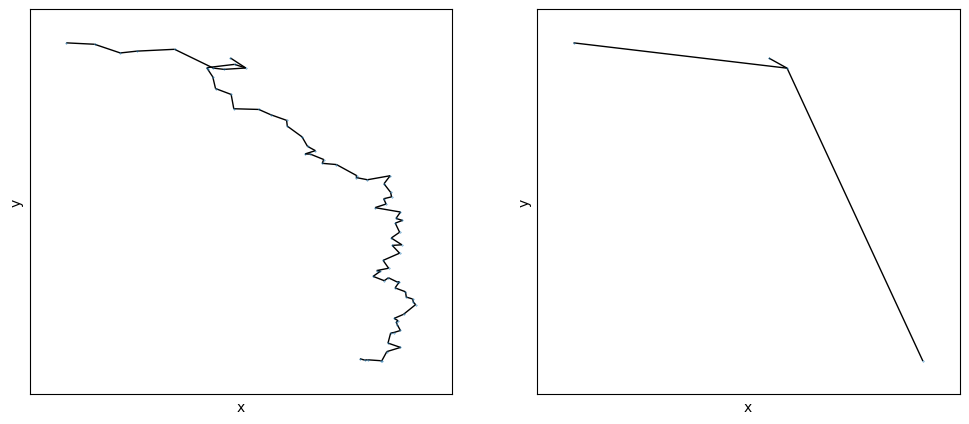

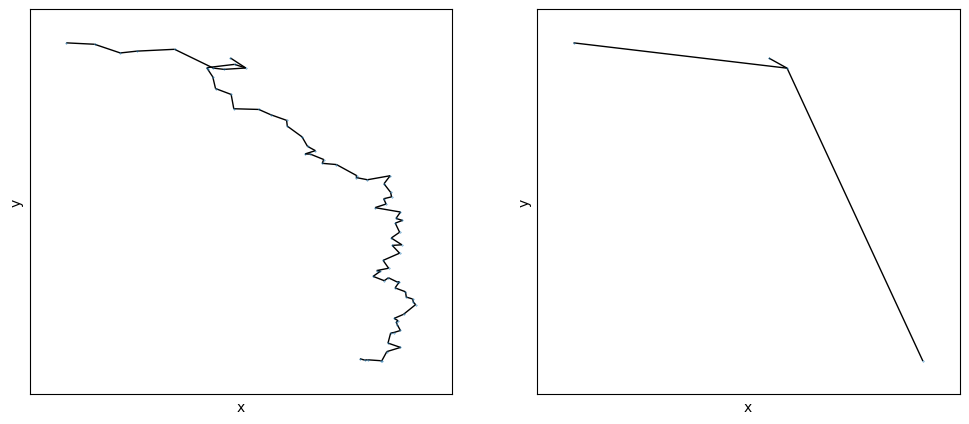

In [ ]:

G = kn.from_therion_sql_enhanced('../data/ReveEveille.sql',
                                # optional input that are stored as metadata on the graph
                                cavename = 'ReveEveille', 
                                crs = 'local', 
                                rights = 'CC-BY-NC-SA 4.0',
                                citation = 'Centre Terre. (2024). Survey Data for the Ultima Patagonia Cave Exploration project [Dataset]. https://github.com/tr1813/ultima-patag')

Kg = kn.from_nxGraph(G, dict(G.nodes('pos')), properties=None, verbose=True)

Kg.plot()

# Clean and add flags

It is possible to create edges and import flags on the nodes or edges.
1. To create one or multiple edges, create dictionnary with the flag as key, and a list of list of node id as values.
    - To create edges that should stay on the graph, use the flag 'add', or any other flags that are not 
    - If the flags : 'srf', 'dpl', 'rmv', 'art', 'spl' are use then they will be, by default removed from the graph
2. To add a node flag, create a dictionnary with the flag as key, and a list of node id to flag.
2. If the edge or node already exist, then a flag will be added edge or node

the node id are the full address, which is the full path describing the station in the sql file. this full address can be found in the  ```fulladdress``` dictionnary attached to the graph

### Flags

Therion node (station) flags: 
- ```ent``` = entrance
- ```con``` = continuation
- ```fix``` = fixed 
- ```spr``` = spring
- ```sin``` = sink
- ```dol``` = doline
- ```dig``` = dig 
- ```air``` = air-draught
- ```ove``` = overhang
- ```arc``` = arch attributes  

Therion edge (shot) flags:
- ```dpl``` = duplicate
- ```srf``` = surface shots 

Other edge flags:
- ```add``` = add
- ```rmv``` = remove
- ```art``` = artificial (ex. tunnel)
- ```spl``` = splay (for example star shape shots in large rooms)

## Example: Clean graph from duplicates and surface points flagged in the Therion sql file.

Therion Import -- Importing all links (including splays) -- 0.23738574981689453s
Therion Import -- Importing all nodes data (including splays) -- 0.266995906829834s
Therion Import -- Create initial graph with all the data points (including splays) -- 0.33901524543762207s
Therion Import -- Combine Stations with identical x,y,z -- 0.6085846424102783s
0/7294 unique positions
1000/7294 unique positions
2000/7294 unique positions
3000/7294 unique positions
4000/7294 unique positions
5000/7294 unique positions
6000/7294 unique positions
7000/7294 unique positions
Therion Import -- Rename nodes -- 14.041046142578125s
0/7294 nodes to rename
1000/7294 nodes to rename
2000/7294 nodes to rename
3000/7294 nodes to rename
4000/7294 nodes to rename
5000/7294 nodes to rename
6000/7294 nodes to rename
7000/7294 nodes to rename
Therion Import -- concatenate old ic in a dictionnary -- 14.158748865127563s
Therion Import -- Relabel nodes -- 14.159747838973999s
Therion Import -- remove self links -- 14.179

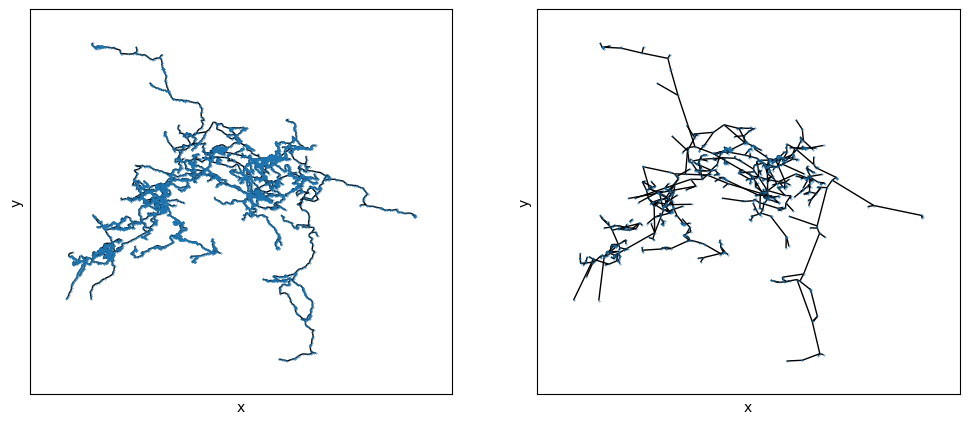

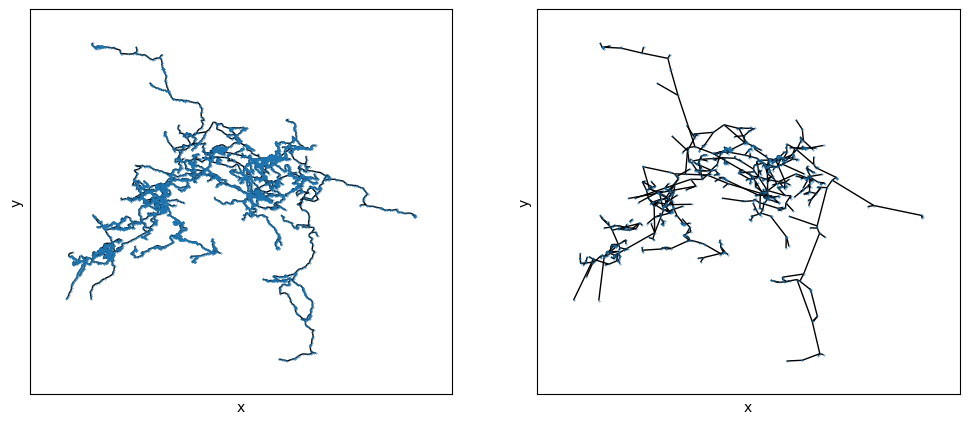

In [ ]:
G = kn.from_therion_sql_enhanced('../data/Migovec.sql',
                                cavename = 'Migovec', 
                                crs = 'epsg:3912', 
                                rights = 'CC-BY-NC-SA 4.0',
                                citation = 'ICCC, & JSDPT. (2024). Survey Data for the Tolminski Migovec Cave Exploration project (Version 2024.03.13) [Dataset]. Zenodo. https://doi.org/DOI: 10.5281/ZENODO.108130')

H = kn.clean_therion_sql_graph(G) # in this case, removing the flagged duplicate and surface points disconnected parts from each other

Kg = kn.from_nxGraph(H, dict(H.nodes('pos')), properties=None, verbose=True)

Kg.plot()

## Example: Adding flags on edges and creating new edes

In [31]:
additional_flags_edges = {'add': [  ['system_migovec.vrtnarija_vilinska.vrtnarija.xanadont.2','system_migovec.vrtnarija_vilinska.vrtnarija.cuckoos_nest.35'],
                                    ['system_migovec.vrtnarija_vilinska.vrtnarija.highway32.12','system_migovec.vrtnarija_vilinska.vrtnarija.gravity.2'],
                                    ['system_migovec.m2m16m18.M16.glory.5','system_migovec.m2m16m18.M16.god.27'],
                                    ['system_migovec.m2m16m18.M16.god.19','system_migovec.m2m16m18.M16.glory.11'],
                                    ['system_migovec.primadona_ubend_mona_tip.mona_tip.mona_tip2.31', 'system_migovec.primadona_ubend_mona_tip.mona_tip.cloacamaxima.49'],
                                    ['system_migovec.m2m16m18.M16.glory.16','system_migovec.m2m16m18.M16.god.15'],
                                    ['system_migovec.m2m16m18.M16.teotihuacan.13','system_migovec.m2m16m18.M16.god.17'],
                                    ['system_migovec.vrtnarija_vilinska.vrtnarija.keti.8','system_migovec.vrtnarija_vilinska.vrtnarija.intravenus_de_milo.1'],
                                    ['system_migovec.vrtnarija_vilinska.vrtnarija.kill_em_all.12','system_migovec.vrtnarija_vilinska.vrtnarija.metal_aven.10'],
                                    ['system_migovec.vrtnarija_vilinska.vilinska.vilcon.4','system_migovec.vrtnarija_vilinska.vrtnarija.judge.8'],
                                    ['system_migovec.vrtnarija_vilinska.vrtnarija.perfidia.14','system_migovec.vrtnarija_vilinska.vrtnarija.cow.1'],
                                    ['system_migovec.vrtnarija_vilinska.vrtnarija.perfidia.7','system_migovec.vrtnarija_vilinska.vrtnarija.republica.16'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.polnoletna.26','system_migovec.primadona_ubend_mona_tip.primadona.milanova.8'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.entirely_my_fault.16','system_migovec.primadona_ubend_mona_tip.primadona.karstaway.7'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.more_like_welding.3','system_migovec.primadona_ubend_mona_tip.primadona.mfi.3'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.TTTr.3','system_migovec.primadona_ubend_mona_tip.primadona.what_a_coincidence.1'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.ajdovscina.1','system_migovec.primadona_ubend_mona_tip.primadona.TTTr.8'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.milanova.9','system_migovec.primadona_ubend_mona_tip.primadona.polnoletna.26'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.poseidon_rift.6','system_migovec.primadona_ubend_mona_tip.primadona.street-wise_hercules.8'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.sweet_baby_jesus.22','system_migovec.primadona_ubend_mona_tip.primadona.hallelujah.1'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.upotyn.8','system_migovec.primadona_ubend_mona_tip.primadona.plumbers_paradise.24'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.plumbers_paradise.25','system_migovec.primadona_ubend_mona_tip.primadona.fenestrator.8'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.apple_crumble.22','system_migovec.primadona_ubend_mona_tip.primadona.pov.15'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.dejavu.1','system_migovec.primadona_ubend_mona_tip.primadona.zima00.17'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.jack_of_hearts.29','system_migovec.primadona_ubend_mona_tip.primadona.smer0.37'],
                                    ['system_migovec.primadona_ubend_mona_tip.primadona.pivnica_resurvey.12','system_migovec.primadona_ubend_mona_tip.primadona.zima00.3']],
                              'rmv': [['system_migovec.vrtnarija_vilinska.vrtnarija.xanadont.2','system_migovec.vrtnarija_vilinska.vrtnarija.xanadont.1'],
                                    ['system_migovec.primadona_ubend_mona_tip.mona_tip.mona_tip2.35','system_migovec.primadona_ubend_mona_tip.mona_tip.cloacamaxima.45'],
                                    ['system_migovec.primadona_ubend_mona_tip.mona_tip.cloacamaxima.45','system_migovec.primadona_ubend_mona_tip.mona_tip.cloacamaxima.46'],
                                    ['system_migovec.primadona_ubend_mona_tip.mona_tip.cloacamaxima.46','system_migovec.primadona_ubend_mona_tip.mona_tip.cloacamaxima.47']]}


G = kn.from_therion_sql_enhanced( '../data/Migovec.sql', 
                                cavename = 'Migovec', 
                                crs = 'epsg:3912', 
                                rights = 'CC-BY-NC-SA 4.0',
                                citation = 'ICCC, & JSDPT. (2024). Survey Data for the Tolminski Migovec Cave Exploration project (Version 2024.03.13) [Dataset]. Zenodo. https://doi.org/DOI: 10.5281/ZENODO.108130')

H = kn.clean_therion_sql_graph(G, additional_flags_edges = additional_flags_edges)

Kg = kn.from_nxGraph(H, dict(H.nodes('pos')), properties=None, verbose=True)

Therion Import -- Importing all links (including splays) -- 0.23515725135803223s
Therion Import -- Importing all nodes data (including splays) -- 0.2591562271118164s
Therion Import -- Create initial graph with all the data points (including splays) -- 0.31641197204589844s
Therion Import -- Combine Stations with identical x,y,z -- 0.6125316619873047s
0/7294 unique positions
1000/7294 unique positions
2000/7294 unique positions
3000/7294 unique positions
4000/7294 unique positions
5000/7294 unique positions
6000/7294 unique positions
7000/7294 unique positions
Therion Import -- Rename nodes -- 13.37418794631958s
0/7294 nodes to rename
1000/7294 nodes to rename
2000/7294 nodes to rename
3000/7294 nodes to rename
4000/7294 nodes to rename
5000/7294 nodes to rename
6000/7294 nodes to rename
7000/7294 nodes to rename
Therion Import -- concatenate old ic in a dictionnary -- 13.49881100654602s
Therion Import -- Relabel nodes -- 13.501787662506104s
Therion Import -- remove self links -- 13.5654

## Example: Adding flags on the nodes

In [ ]:
additional_flags_nodes = {  'con': ['ReveEveille.cpff.23', 'ReveEveille.Suite.9'],
                            'inl': ['ReveEveille.CPF.4', 'ReveEveille.cpff.4', 'ReveEveille.cpff.38', 'ReveEveille.cpff.30'],
                            'oul': ['ReveEveille.Suite.16'],
                            'smp': ['ReveEveille.Suite.24'],
                            'wtf': ['ReveEveille.Suite.14']}


G = kn.from_therion_sql_enhanced('../data/ReveEveille.sql',
                                                cavename = 'ReveEveille', 
                                                additional_flags_nodes = additional_flags_nodes,
                                                crs = 'local', 
                                                rights = 'CC-BY-NC-SA',
                                                citation = 'Centre Terre. (2024). Survey Data for the Ultima Patagonia Cave Exploration project [Dataset]. https://github.com/tr1813/ultima-patag')

H = kn.clean_therion_sql_graph(G, additional_flags_nodes = additional_flags_nodes)

Kg = kn.from_nxGraph(H, dict(H.nodes('pos')), properties=None, verbose=True)

Kg.plot()

AttributeError: module 'karstnet' has no attribute 'from_therion_sql_enhanced'